In [2]:
#!/usr/bin/env python3
"""
FRED fetch + cleaning + regression-ready transforms (2002->latest).
- Works in Jupyter (parse_known_args) and CLI.
- Uses REST (deps: pandas, requests, numpy, statsmodels, scikit-learn [optional]).
Outputs:
  - fred_monthly_raw.csv   (monthly-aligned raw panel)
  - fred_reg_ready.csv     (engineered + mostly stationary features)
"""

from __future__ import annotations
import os, sys, time, argparse
from typing import Dict, List
import numpy as np
import pandas as pd
import requests

os.environ["FRED_API_KEY"] = "0edd0176511cb5f2acbd2333dcbe28b1"

# Optional (ADF test + scaler)
try:
    from statsmodels.tsa.stattools import adfuller
except Exception:
    adfuller = None

FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"

# ---------------------------- Configuration ---------------------------- #

SERIES: Dict[str, str] = {
    # ID : Friendly name
    "BAMLC0A0CMEY": "ICE BofA US Corporate Index Effective Yield (IG, %) [Daily]",
    "BAMLH0A0HYM2EY": "ICE BofA US High Yield Index Effective Yield (HY, %) [Daily]",
    "BAMLC0A0CM": "ICE BofA US Corporate Index OAS (bp) [Daily]",
    "BAMLH0A0HYM2": "ICE BofA US High Yield Index OAS (bp) [Daily]",
    "VIXCLS": "CBOE VIX [Daily]",
    "DGS10": "UST 10Y CMT (%) [Daily]",
    "DGS5":  "UST 5Y CMT (%) [Daily]",
    "DGS2":  "UST 2Y CMT (%) [Daily]",
    "DGS30": "UST 30Y CMT (%) [Daily]",
    "CPIAUCSL": "CPI All Items (SA, 1982-84=100) [Monthly]",
    "CPILFESL": "Core CPI ex Food & Energy (SA) [Monthly]",
    "UNRATE": "Unemployment Rate (SA, %) [Monthly]",
    "CCSA": "Continued Claims (SA, weekly, persons) [Weekly]",
    "T10YIE": "10-Year Breakeven Inflation Rate",
    "T5YIE": "5-Year Breakeven Inflation Rate",
    "T5YIFR": "5-Year, 5-Year Forward Inflation Expectation Rate",
    "INDPRO": "Industrial Production",
    "PCEPI": "Personal Consumption Expenditure"
}

# Categorize for sensible resampling
DAILY = {"BAMLC0A0CMEY","BAMLH0A0HYM2EY","BAMLC0A0CM","BAMLH0A0HYM2","VIXCLS","DGS10","DGS5","DGS2","DGS30","T10YIE","T5YIE","T5YIFR"}
WEEKLY = {"CCSA"}
MONTHLY = {"CPIAUCSL","CPILFESL","UNRATE","INDPRO","PCEPI"}

START_DEFAULT = "1999-12-31"
END_DEFAULT = "9999-12-31"

# ---------------------------- Fetching ---------------------------- #

def fetch_series_rest(series_id: str, api_key: str, start: str, end: str) -> pd.Series:
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start,
        "observation_end": end,
    }
    r = requests.get(FRED_BASE, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    obs = data.get("observations", [])
    if not obs:
        return pd.Series(name=series_id, dtype="float64")
    df = pd.DataFrame(obs)[["date", "value"]]
    # '.' denotes missing; coerce to NaN and numeric
    df["value"] = pd.to_numeric(df["value"].replace(".", pd.NA), errors="coerce")
    s = df.set_index(pd.to_datetime(df["date"]))["value"].rename(series_id)
    return s

def fetch_all_series(series_ids: List[str], api_key: str, start: str, end: str, sleep_s: float=0.0) -> pd.DataFrame:
    frames = []
    for i, sid in enumerate(series_ids, 1):
        s = fetch_series_rest(sid, api_key, start, end)
        frames.append(s)
        if sleep_s and i < len(series_ids):
            time.sleep(sleep_s)
    return pd.concat(frames, axis=1).sort_index()

# ---------------------------- Harmonize to Monthly ---------------------------- #

def to_monthly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert mixed-frequency panel to monthly index:
    - DAILY series -> monthly mean
    - WEEKLY series -> monthly mean
    - MONTHLY series -> aligned to month-end
    Then forward-fill a small gap after resampling.
    """
    out = {}
    for col in df.columns:
        if col in DAILY:
            out[col] = df[col].resample('ME').mean()
        elif col in WEEKLY:
            out[col] = df[col].resample('ME').mean()
        elif col in MONTHLY:
            # Ensure month-end alignment
            s = df[col].copy()
            # Many monthly series come with month stamps; resample to month-end via last valid value in month
            out[col] = s.resample('ME').last()
        else:
            # Fallback: monthly mean
            out[col] = df[col].resample('ME').mean()
    m = pd.concat(out, axis=1).sort_index()
    # Light forward-fill to patch end-of-month publishing gaps (max 5 days worth of missing after resampling)
    m = m.ffill(limit=1)
    return m

# ---------------------------- Feature Engineering ---------------------------- #

def pct_change_yoy(x: pd.Series) -> pd.Series:
    return x.pct_change(12, fill_method = None) * 100.0

def delta_bp(x: pd.Series) -> pd.Series:
    """Monthly change in basis points for % or bp series (approx)."""
    return (x - x.shift(1)) * 100.0

def safe_log1p(x: pd.Series) -> pd.Series:
    return np.log1p(np.clip(x, a_min=0, a_max=None))

def build_features(monthly: pd.DataFrame) -> pd.DataFrame:
    """
    Build a regression-friendly feature set:
      - YoY inflation (headline & core)
      - Term spread (10Y-2Y), slope changes
      - Credit OAS levels + monthly changes
      - Treasury yield changes (bp)
      - Unemployment (level) + Δ
      - VIX level + log(1+VIX) + Δ
      - Continued claims level + Δ (avg monthly already)
      - IG/HY effective yields level + Δ
    """
    m = monthly.copy()

    # Basic spreads and slopes
    m["TERM_10Y_2Y"] = m["DGS10"] - m["DGS2"]
    m["TERM_30Y_5Y"] = m["DGS30"] - m["DGS5"]

    # Inflation YoY (CPI series are SA monthly)
    m["CPI_YoY"] = pct_change_yoy(m["CPIAUCSL"])
    m["CORECPI_YoY"] = pct_change_yoy(m["CPILFESL"])
    m["PCEPI_YoY"] = pct_change_yoy(m["PCEPI"])
    m["INDPRO_YoY"] = pct_change_yoy(m["INDPRO"])

    # Unemployment level & change (pp)
    m["UNRATE_dpp"] = m["UNRATE"] - m["UNRATE"].shift(1)

    # Treasury yield changes in bp
    for c in ["DGS2","DGS5","DGS10","DGS30"]:
        m[f"{c}_dbp"] = delta_bp(m[c])

    # Credit spreads (bp) + monthly change
    for c in ["BAMLC0A0CM","BAMLH0A0HYM2"]:
        m[f"{c}_dbp"] = delta_bp(m[c])

    # Effective yields (%) + monthly change
    for c in ["BAMLC0A0CMEY","BAMLH0A0HYM2EY","T10YIE","T5YIE","T5YIFR"]:
        m[f"{c}_dbp"] = delta_bp(m[c])

    # VIX levels, log1p, and change
    m["VIX_log1p"] = safe_log1p(m["VIXCLS"])
    m["VIX_d"] = m["VIXCLS"] - m["VIXCLS"].shift(1)

    # Continued claims (level already monthly avg) + change
    m["CCSA_d"] = m["CCSA"] - m["CCSA"].shift(1)

    # Some common composites
    m["CREDIT_SLOPE_dbp"] = m["BAMLH0A0HYM2_dbp"] - m["BAMLC0A0CM_dbp"]  # change in HY vs IG OAS
    m["YIELD_SLOPE_dbp"]  = m["DGS10_dbp"] - m["DGS2_dbp"]

    return m

# ---------------------------- I/O + Main ---------------------------- #

def parse_args():
    p = argparse.ArgumentParser(description="FRED 2002+ fetch and regression-ready cleaning")
    p.add_argument("--api-key", default=os.getenv("FRED_API_KEY"), help="FRED API key (or set FRED_API_KEY).")
    p.add_argument("--start", default=START_DEFAULT)
    p.add_argument("--end", default=END_DEFAULT)
    p.add_argument("--out-raw", default="data/fred_monthly_raw.csv")
    p.add_argument("--out-reg", default="data/fred_reg_ready.csv")
    p.add_argument("--sleep", type=float, default=0.0, help="Sleep seconds between fetches (rate limit friendly).")
    return p

def main(argv: List[str] | None = None):
    parser = parse_args()
    args, _unk = parser.parse_known_args(argv)

    if not args.api_key:
        sys.stderr.write("Error: provide FRED API key via --api-key or FRED_API_KEY env.\n")
        sys.exit(1)

    # 1) Fetch full history then clip to 2002+
    df = fetch_all_series(list(SERIES.keys()), api_key=args.api_key,
                          start="1900-01-01", end=args.end, sleep_s=args.sleep)
    df = df.loc[pd.to_datetime(args.start):]  # enforce 2002+

    # 2) Harmonize to monthly panel + light fill
    monthly = to_monthly(df)

    # 3) Add readable column names as a MultiIndex (ID, Description)
    monthly.columns = pd.MultiIndex.from_tuples([(c, SERIES.get(c, c)) for c in monthly.columns],
                                                names=["FRED_ID","Description"])

    # Save raw monthly panel (levels)
    monthly.to_csv(args.out_raw, index_label="Date")
    print(f"Wrote monthly raw panel: {args.out_raw}")

    # 4) Build engineered features on a flat copy
    monthly_flat = monthly.copy()
    monthly_flat.columns = [t[0] for t in monthly_flat.columns]  # keep only IDs
    feats = build_features(monthly_flat)

    # 5) Final tidy: drop rows with all-NaN, and keep from 2002+
    reg_ready = feats.loc[pd.to_datetime(START_DEFAULT):].copy()
    # It’s common to drop first 12 months due to YoY/Δ creation
    reg_ready = reg_ready.dropna(how="all")
    # Mild forward-fill for a couple of late-reporting macros (optional)
    reg_ready = reg_ready.ffill(limit=1)

    reg_ready.to_csv(args.out_reg, index_label="Date")
    print(f"Wrote regression-ready features: {args.out_reg}")

if __name__ == "__main__":
    # Example in Jupyter:
    #   import os; os.environ["FRED_API_KEY"] = "YOUR_KEY"
    #   main([])
    main()


Wrote monthly raw panel: data/fred_monthly_raw.csv
Wrote regression-ready features: data/fred_reg_ready.csv


In [3]:
reg_ready = pd.read_csv('data/fred_reg_ready.csv')

In [11]:
reg_ready.columns

Index(['Date', 'BAMLC0A0CMEY', 'BAMLH0A0HYM2EY', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
       'VIXCLS', 'DGS10', 'DGS5', 'DGS2', 'DGS30', 'CPIAUCSL', 'CPILFESL',
       'UNRATE', 'CCSA', 'T10YIE', 'T5YIE', 'T5YIFR', 'INDPRO', 'PCEPI',
       'TERM_10Y_2Y', 'TERM_30Y_5Y', 'CPI_YoY', 'CORECPI_YoY', 'PCEPI_YoY',
       'INDPRO_YoY', 'UNRATE_dpp', 'DGS2_dbp', 'DGS5_dbp', 'DGS10_dbp',
       'DGS30_dbp', 'BAMLC0A0CM_dbp', 'BAMLH0A0HYM2_dbp', 'BAMLC0A0CMEY_dbp',
       'BAMLH0A0HYM2EY_dbp', 'T10YIE_dbp', 'T5YIE_dbp', 'T5YIFR_dbp',
       'VIX_log1p', 'VIX_d', 'CCSA_d', 'CREDIT_SLOPE_dbp', 'YIELD_SLOPE_dbp'],
      dtype='object')

In [12]:
reg_ready.isnull().values[0]

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True])

In [5]:
reg_ready.columns

Index(['Date', 'BAMLC0A0CMEY', 'BAMLH0A0HYM2EY', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
       'VIXCLS', 'DGS10', 'DGS5', 'DGS2', 'DGS30', 'CPIAUCSL', 'CPILFESL',
       'UNRATE', 'CCSA', 'T10YIE', 'T5YIE', 'T5YIFR', 'INDPRO', 'PCEPI',
       'TERM_10Y_2Y', 'TERM_30Y_5Y', 'CPI_YoY', 'CORECPI_YoY', 'PCEPI_YoY',
       'INDPRO_YoY', 'UNRATE_dpp', 'DGS2_dbp', 'DGS5_dbp', 'DGS10_dbp',
       'DGS30_dbp', 'BAMLC0A0CM_dbp', 'BAMLH0A0HYM2_dbp', 'BAMLC0A0CMEY_dbp',
       'BAMLH0A0HYM2EY_dbp', 'T10YIE_dbp', 'T5YIE_dbp', 'T5YIFR_dbp',
       'VIX_log1p', 'VIX_d', 'CCSA_d', 'CREDIT_SLOPE_dbp', 'YIELD_SLOPE_dbp'],
      dtype='object')

In [6]:
import matplotlib.pyplot as plt

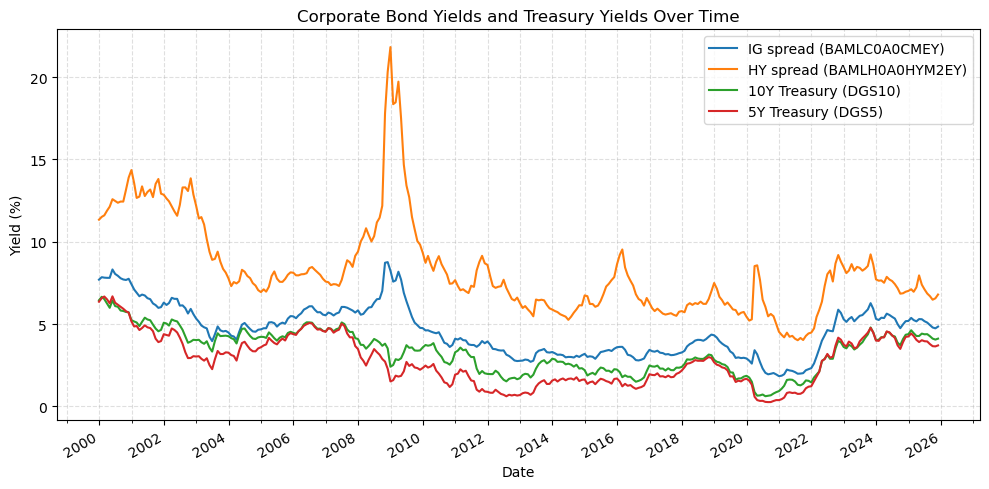

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure Date is datetime and set as index
reg_ready["Date"] = pd.to_datetime(reg_ready["Date"])
reg_ready = reg_ready.sort_values("Date").set_index("Date")

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(reg_ready.index, reg_ready["BAMLC0A0CMEY"], label="IG spread (BAMLC0A0CMEY)")
ax.plot(reg_ready.index, reg_ready["BAMLH0A0HYM2EY"], label="HY spread (BAMLH0A0HYM2EY)")
ax.plot(reg_ready.index, reg_ready["DGS10"], label="10Y Treasury (DGS10)")
ax.plot(reg_ready.index, reg_ready["DGS5"], label="5Y Treasury (DGS5)")

ax.set_title("Corporate Bond Yields and Treasury Yields Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Yield (%)")

# Nice date formatting
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))    # every 2 years
ax.xaxis.set_minor_locator(mdates.YearLocator())          # every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()  # rotate & align dates
ax.grid(True, which="both", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()


In [11]:
df = pd.read_csv("data/data_wo_lqd.csv")
df["dIG_spread"] = df["IG_spread"].diff()
df["dHY_spread"] = df["HY_spread"].diff()

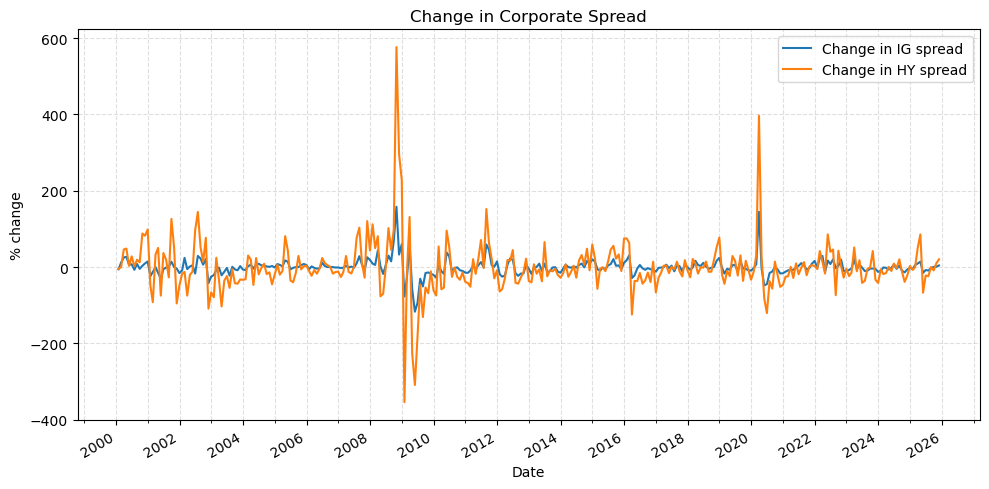

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure Date is datetime and set as index
df["date"] = pd.to_datetime(reg_ready.index)
df = df.sort_values("date").set_index("date")

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df.index, df["dIG_spread"], label="Change in IG spread")
ax.plot(df.index, df["dHY_spread"], label="Change in HY spread")

ax.set_title("Change in Corporate Spread")
ax.set_xlabel("Date")
ax.set_ylabel("% change")

# Nice date formatting
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))    # every 2 years
ax.xaxis.set_minor_locator(mdates.YearLocator())          # every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()  # rotate & align dates
ax.grid(True, which="both", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()

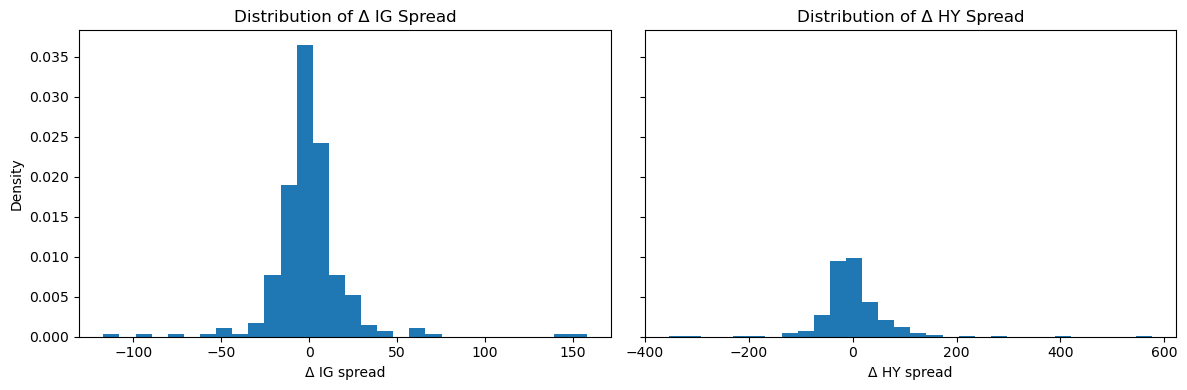

In [20]:
import matplotlib.pyplot as plt

# Assuming reg_ready already has dIG_spread and dHY_spread
ig = df["dIG_spread"].dropna()
hy = df["dHY_spread"].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# IG spread distribution
axes[0].hist(ig, bins=30, density=True)
axes[0].set_title("Distribution of Δ IG Spread")
axes[0].set_xlabel("Δ IG spread")
axes[0].set_ylabel("Density")

# HY spread distribution
axes[1].hist(hy, bins=30, density=True)
axes[1].set_title("Distribution of Δ HY Spread")
axes[1].set_xlabel("Δ HY spread")

plt.tight_layout()
plt.show()


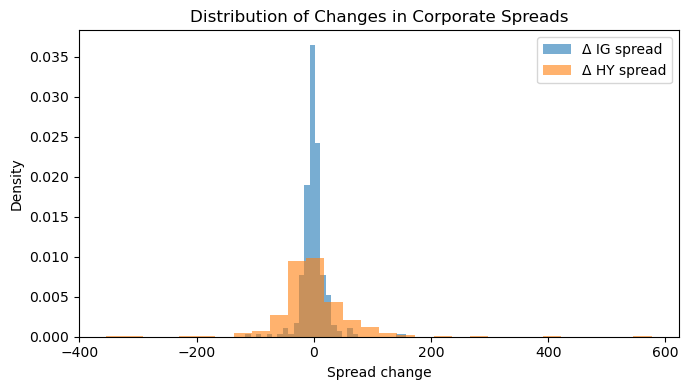

In [21]:
plt.figure(figsize=(7, 4))
plt.hist(ig, bins=30, density=True, alpha=0.6, label="Δ IG spread")
plt.hist(hy, bins=30, density=True, alpha=0.6, label="Δ HY spread")

plt.title("Distribution of Changes in Corporate Spreads")
plt.xlabel("Spread change")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
